<a href="https://colab.research.google.com/github/matand380/DNN_final_project_2024/blob/main/DNN_final_project_2024_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Deep Learning - Final Project** 🖥

## Team Information
- **Course:** Introduction to Deep Learning

- **Semester:** Fall 2024

- **Lectrurer:** Dr. Moshe Butman

- **Institution:** The College of Management Academic Studies

- **Team Members:** Eviatar Didon 313205387, Matan Drabkin 201416690

## Project Overview

### Objective

This project centers around the application of deep learning techniques to classify chest X-ray images into distinct categories,

with a specific emphasis on differentiating between healthy cases and those diagnosed with pneumonia.

The dataset for training and evaluation includes a total of 5863 X-ray images, categorized as follows:

- A. **Healthy**
- B. **Pneumonia**
  - Bacterial Pneumonia
  - Viral Pneumonia



### Define imports
**always run the above cell first:**

In [3]:
import gdown
import os
import cv2
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Input, Conv2DTranspose, Reshape
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Precision, Recall
from keras import backend as K

from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from google.colab import drive, files


from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


# <font color=burlywood>Dataset Downloading and Exploration</font>

### Prerequisites

Execute the code cell below to download the dataset ZIP file from Google Drive and extract its contents.

In [ ]:
# download the dataset from google drive
file_id = '1-7nq09-oeUTz5wk5hUre3wEiDfuESb52'

output_path = '/content/chest-xray-pneumonia.zip'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)

!unzip chest-xray-pneumonia.zip

- *execute this cell **only if** gdown approach doesn't work (kaggle.json is submitted in the Moodle)*

In [1]:
############# Only if gdown doesn't work ###########
!pip install kaggle
from google.colab import files

uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

- create pathes and dataframes

In [4]:
# Define paths and DataFrames

def create_dataframe_from_directory(directory):
    file_paths = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file_name)
            file_paths.append(file_path)
            labels.append(label)
    return pd.DataFrame({'file_path': file_paths, 'class': labels})

# Paths
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# DataFrames
train_df = create_dataframe_from_directory(train_dir)
val_df = create_dataframe_from_directory(val_dir)
test_df = create_dataframe_from_directory(test_dir)

In [5]:
#Mount your google drive for saving models and weights
drive.mount('/content/gdrive')

drive_path = '/content/gdrive/My Drive/Colab Notebooks/DNN_final_project_2024'

Mounted at /content/gdrive


### Data exploration

Let's begin by exploring a selection of images accompanied by brief explanations about the dataset.

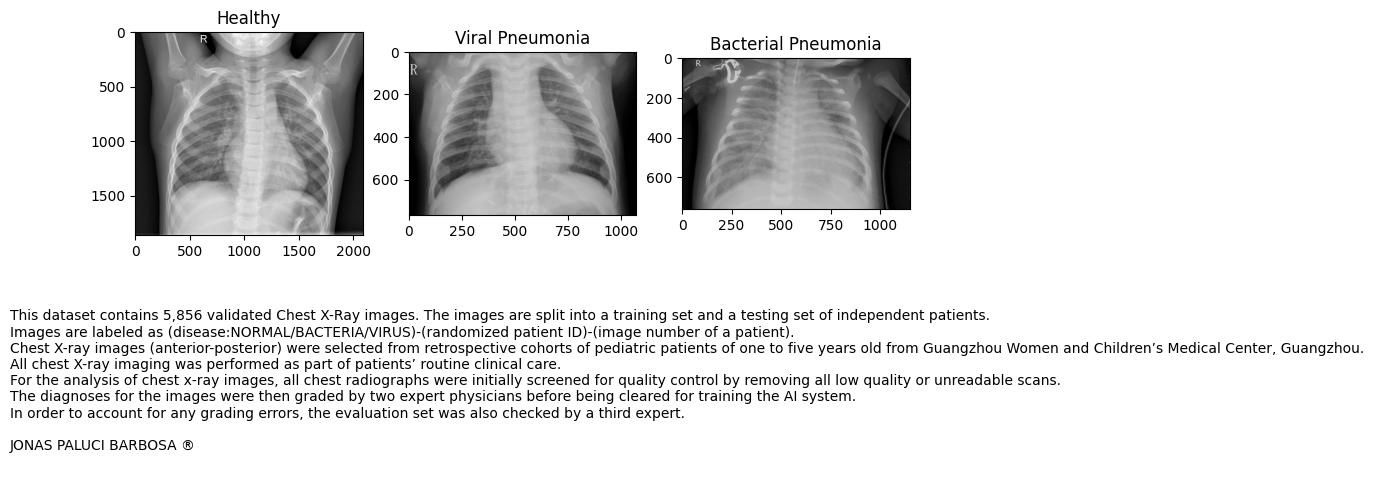

In [ ]:

healthy_image_path = '/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
viral_pneumonia_image_path = '/content/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg'
bacterial_pneumonia_image_path = '/content/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'

healthy_image = cv2.imread(healthy_image_path)
viral_pneumonia_image = cv2.imread(viral_pneumonia_image_path)
bacterial_pneumonia_image = cv2.imread(bacterial_pneumonia_image_path)

# Convert BGR images to RGB
healthy_image = cv2.cvtColor(healthy_image, cv2.COLOR_BGR2RGB)
viral_pneumonia_image = cv2.cvtColor(viral_pneumonia_image, cv2.COLOR_BGR2RGB)
bacterial_pneumonia_image = cv2.cvtColor(bacterial_pneumonia_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(healthy_image)
plt.title('Healthy')

plt.subplot(1, 3, 2)
plt.imshow(viral_pneumonia_image)
plt.title('Viral Pneumonia')

plt.subplot(1, 3, 3)
plt.imshow(bacterial_pneumonia_image)
plt.title('Bacterial Pneumonia')
text = """
This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients.
Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou.
All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans.
The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system.
In order to account for any grading errors, the evaluation set was also checked by a third expert.

JONAS PALUCI BARBOSA ®
"""

plt.figtext(0.0, -0.000000000015, text, size=10, ha="left", va="center")


plt.show()


Let's examine the distribution of train and test sets. Validation set is very small and we will concatenate it later to train.

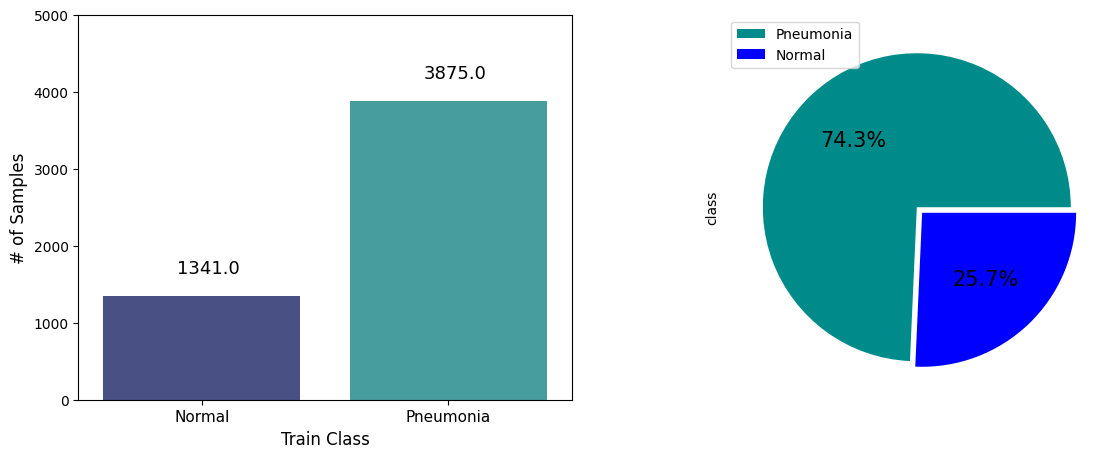

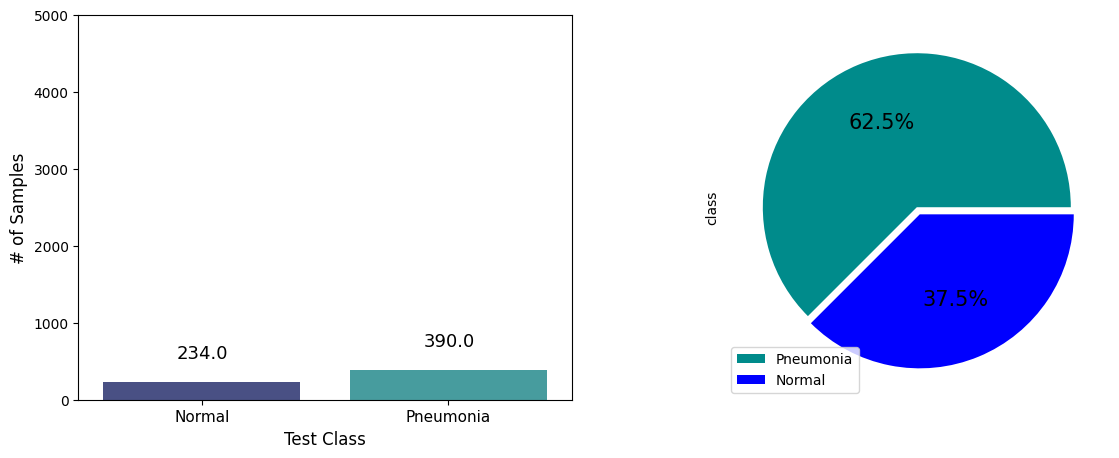

In [ ]:
#Graphs for the train set
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = sns.countplot(x='class', hue='class', data=train_df, palette="mako", ax=axes[0], legend=False)
ax1.set_xlabel("Train Class", fontsize=12)
ax1.set_ylabel("# of Samples", fontsize=12)
ax1.set_ylim(0, 5000)
ax1.set_xticks([0, 1])
ax1.set_xticklabels([  'Normal', 'Pneumonia'], fontsize=11)

for p in ax1.patches:
    ax1.annotate((p.get_height()), (p.get_x() + 0.30, p.get_height() + 300), fontsize=13)

ax2 = axes[1]
train_df['class'].value_counts().plot(kind='pie', labels=['', ''], autopct='%1.1f%%', colors=['darkcyan', 'blue'],
                                      explode=[0, 0.05], textprops={"fontsize": 15})
ax2.legend(labels=['Pneumonia', 'Normal'])

plt.show()

#Graphs for the test set
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = sns.countplot(x='class', hue='class', data=test_df, palette="mako", ax=axes[0], legend=False)
ax1.set_xlabel("Test Class", fontsize=12)
ax1.set_ylabel("# of Samples", fontsize=12)
ax1.set_ylim(0, 5000)
ax1.set_xticks([0, 1])
ax1.set_xticklabels([  'Normal', 'Pneumonia'], fontsize=11)

for p in ax1.patches:
    ax1.annotate((p.get_height()), (p.get_x() + 0.30, p.get_height() + 300), fontsize=13)


ax2 = axes[1]
test_df['class'].value_counts().plot(kind='pie', labels=['', ''], autopct='%1.1f%%', colors=['darkcyan', 'blue'],
                                      explode=[0, 0.05], textprops={"fontsize": 15})
ax2.legend(labels=['Pneumonia', 'Normal'])

plt.show()


We can see that the dataset is a bit imbalance. we will create augmentations later in order to deal with this.

# <font color=crimson>Binary classification - Healthy vs Pneumonia</font>
In this section, the aim is to implement a binary classification neural network to distinguish between healthy and diseased images.

## Preprocessing - Data augmentation and normalization

In [6]:

# Paths
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

## Reorganization of the data

In the original data there's only 16 samples for the validation set. At the first training we got overfitting so we reorganized the samples in order to get more balanced data.

In [7]:

# We load all file paths in the training and validation directories and combine them
all_train_files = []
for root, dirs, files in os.walk(train_dir):
    all_train_files.extend([os.path.join(root, file) for file in files])

all_val_files = []
for root, dirs, files in os.walk(val_dir):
    all_val_files.extend([os.path.join(root, file) for file in files])

all_files = all_train_files + all_val_files

random.shuffle(all_files)

labels = [os.path.basename(os.path.dirname(file)) for file in all_files]

# Split the into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, labels, test_size=0.2, random_state=42, stratify=labels
)

# DataGenerators for training and validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True

)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary',
     shuffle=False
)

# Test generator for evaluation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary',
     shuffle=False

)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Custom Model from scratch


- We tried setting the lreaning rate to 0.01 but we got worse results than 0.
001 (which is the default for Adam optimizer). Afterwards we changed it to 0.0001.

- We discovered that adding more filters improve the network ability to learn more hierarchical features and got much better results.

- We increased the dense layer from 128 to 512 because we thought we are loosing important information. afterwards we added one more dense layer and changed to 1024

- We added L2 regularization and Batch normalization
- We decreased image size to 64 x 64 let the model learn more detials


In [8]:

model = Sequential()



model.add(Conv2D(filters=64,kernel_size=(3, 3), input_shape=(64, 64, 3), activation='relu', padding='valid', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=(3, 3), activation='relu', padding='valid', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=(3, 3), activation='relu', padding='valid', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(filters=128,kernel_size=(3, 3), activation='relu', padding='valid', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=(3, 3), activation='relu', padding='valid', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=(3, 3), activation='relu', padding='valid', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(units=1024, activation='relu', kernel_regularizer=l2(0.01),name='ev'))
model.add(Dense(units=1024, activation='relu', kernel_regularizer=l2(0.01)))


model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 62, 62, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 60, 60, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 64)        36928     
                                                                 
 batch_normalization_2 (Bat  (None, 58, 58, 64)        2

In [9]:

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f'{drive_path}/binary_best_model.keras', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10
131/131 [==============================] - 103s 724ms/step - loss: 28.9220 - accuracy: 0.8903 - val_loss: 24.5512 - val_accuracy: 0.7421
Epoch 2/10
131/131 [==============================] - 43s 330ms/step - loss: 18.9245 - accuracy: 0.9321 - val_loss: 16.4353 - val_accuracy: 0.7421
Epoch 3/10
131/131 [==============================] - 43s 329ms/step - loss: 12.8303 - accuracy: 0.9372 - val_loss: 12.0444 - val_accuracy: 0.7421
Epoch 4/10
131/131 [==============================] - 43s 329ms/step - loss: 9.1721 - accuracy: 0.9381 - val_loss: 7.8720 - val_accuracy: 0.9351
Epoch 5/10
131/131 [==============================] - 43s 331ms/step - loss: 6.8901 - accuracy: 0.9395 - val_loss: 6.0103 - val_accuracy: 0.9580
Epoch 6/10
131/131 [==============================] - 43s 327ms/step - loss: 5.3761 - accuracy: 0.9527 - val_loss: 4.8010 - val_accuracy: 0.9494
Epoch 7/10
131/131 [==============================] - 43s 328ms/step - loss: 4.3345 - accuracy: 0.9496 - val_loss: 3.9269 -

In [10]:
print("Training Accuracy:", round(history.history['accuracy'][-1], 3))
print("Training Loss:", round(history.history['loss'][-1], 3))

Training Accuracy: 0.957
Training Loss: 2.578


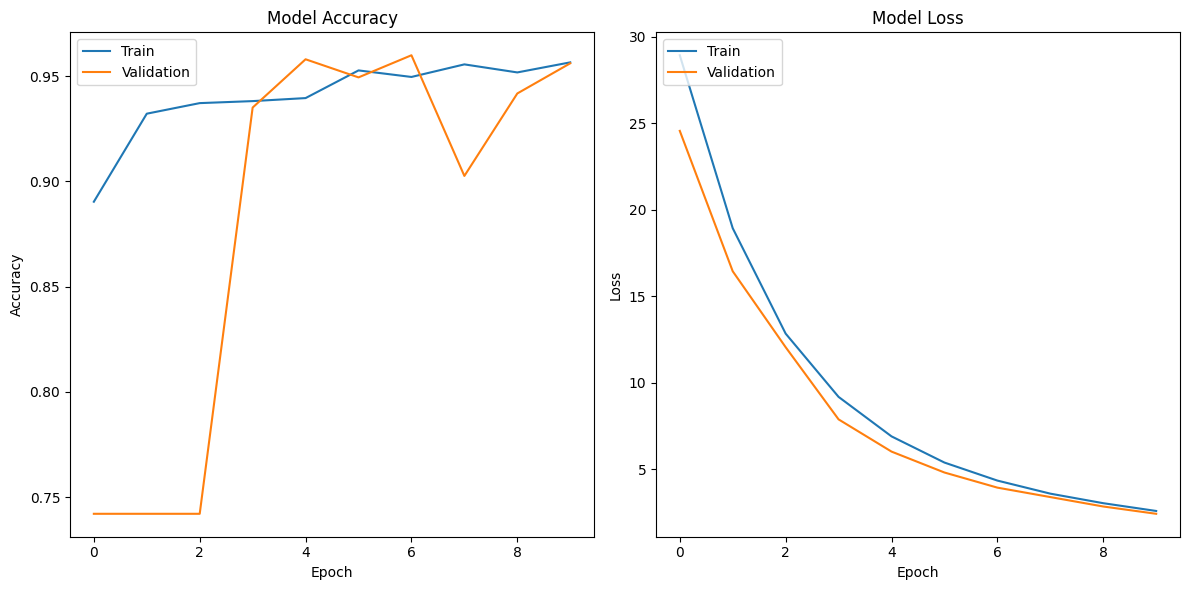

In [11]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Show the plots
    plt.tight_layout()
    plt.show()

plot_training_history(history)

- Save the best model and its weights

In [13]:
model.save(f'{drive_path}/binary_best_model.keras')

## Binary model evaluation

- download the binary model and the trained weights and load it
- run the preprocess section so that the loaded model will have data to work on

In [14]:
import gdown
from keras.models import load_model
file_id = '1NLnOMxL7D_LPRMlfWXk1cKvZvOJ7YCvw'

download_url = f"https://drive.google.com/uc?id={file_id}"
model_filename = 'binary_best_model.keras'

# Download the model file
gdown.download(download_url, model_filename, quiet=False)

# Load the downloaded model using Keras
binary_model = load_model(model_filename)



Downloading...
From (original): https://drive.google.com/uc?id=1NLnOMxL7D_LPRMlfWXk1cKvZvOJ7YCvw
From (redirected): https://drive.google.com/uc?id=1NLnOMxL7D_LPRMlfWXk1cKvZvOJ7YCvw&confirm=t&uuid=09fa2587-f47b-434f-b2bb-e20e7a37f2f9
To: /content/binary_best_model.keras
100%|██████████| 208M/208M [00:01<00:00, 156MB/s]


In [15]:

binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluation_result = binary_model.evaluate(test_generator, steps=len(test_generator))

test_loss = evaluation_result[0]
test_accuracy = evaluation_result[1]

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


20/20 [==============================] - 4s 183ms/step - loss: 2.5387 - accuracy: 0.9038
Test Loss: 2.5387
Test Accuracy: 90.38%


20/20 [==============================] - 4s 185ms/step
Accuracy: 90.38%



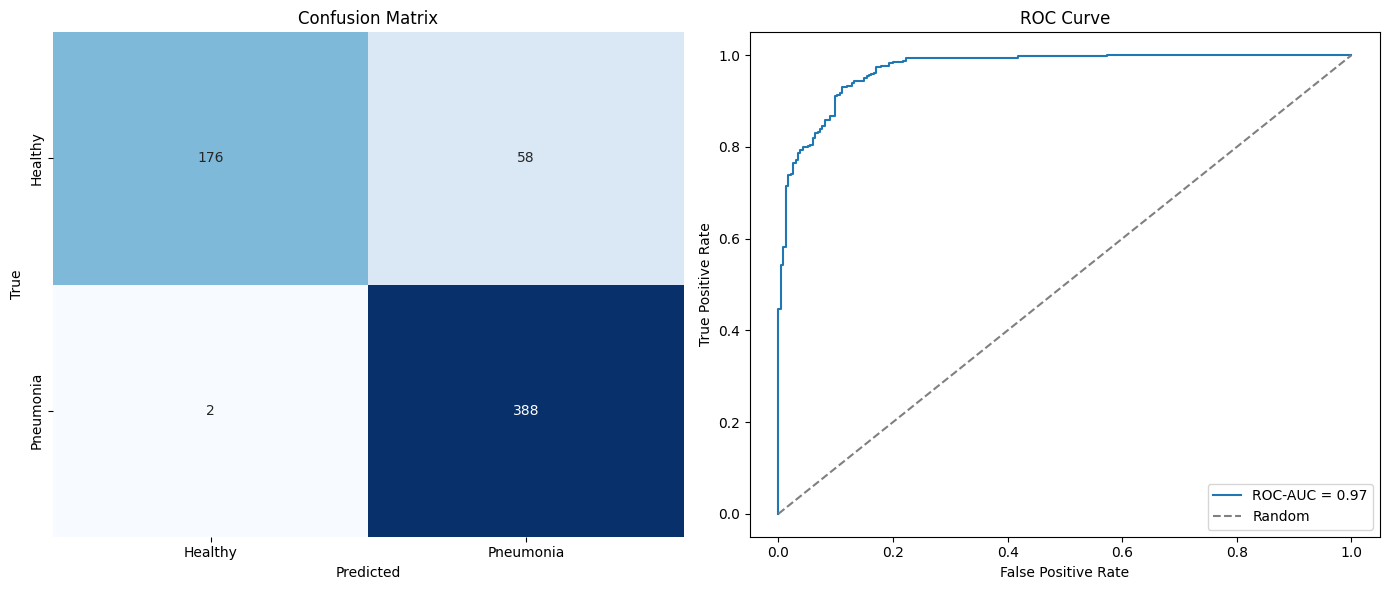

In [16]:
# Make predictions on the test set
y_pred_prob = binary_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5)

y_true = test_generator.classes
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print()

class_labels = ['Healthy', 'Pneumonia']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels,
            ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix')

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
axes[1].plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()

plt.tight_layout()
plt.show()


Uplopad image of your own for prediction:
1. Drag & Drop the image to the file manager in the colab notebook
2. copy its path and paste it in the "image_path" variable.
3. Run the cell

(`files.upload()` didn't work)


In [ ]:
class_labels = ['Healthy', 'Pneumonia']

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values
    return img_array

def predict_image(image_path):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    if prediction > 0.5:
      return class_labels[1]
    else:
      return class_labels[0]

#########################################
image_path = 'paste_your_image_path_here'
#########################################

predicted = predict_image(image_path)

print("Predicted class:", predicted)


Image path: /content/IM-0001-0001.jpeg
1/1 [==============================] - 0s 19ms/step
Predicted class: Healthy


# <font color=teal>Multi-class classification - Healthy, Viral and Bacteria</font>
In this task, the objective is to address the problem using a deep neural network for multi-class classification. The network will categorize images into three classes: healthy, diseased with viral pneumonia, and diseased with bacterial pneumonia. in this implementation we chose to use transfer learning technique.

## Preprocessing for multi-class

In [19]:
# Paths
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# Function to extract labels from file paths
def extract_labels(file_paths):
    labels = []
    for file_path in file_paths:
        if 'virus' in file_path:
            labels.append('viral')
        elif 'bacteria' in file_path:
            labels.append('bacterial')
        else:
            labels.append('normal')
    return labels

all_train_files = []
for root, dirs, files in os.walk(train_dir):
    all_train_files.extend([os.path.join(root, file) for file in files])

all_val_files = []
for root, dirs, files in os.walk(val_dir):
    all_val_files.extend([os.path.join(root, file) for file in files])

all_files = all_train_files + all_val_files

random.shuffle(all_files)

test_files = []
for root, dirs, files in os.walk(test_dir):
    test_files.extend([os.path.join(root, file) for file in files])

# Extract labels from file paths
labels = extract_labels(all_files)
test_labels = extract_labels(test_files)


# Split the data into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, labels, test_size=0.2, random_state=42, stratify=labels
)

# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_mc = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical',
    shuffle=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator_mc = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical',
    shuffle=False
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator_mc = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical',
    shuffle=False
)


Found 4185 validated image filenames belonging to 3 classes.
Found 1047 validated image filenames belonging to 3 classes.
Found 624 validated image filenames belonging to 3 classes.


## Transfer learning model

- First, we did some iterations on the binray model with changes to 3 classes and softmax activation function.
- After that we decided to try to implement transfer learning technique with pretrained model ResNet50.
- First, we trained the model "as is".
- Afterwords we changed learning rate from 0.001 to 0.0001
- After few experiments we chose to freeze the first 3 blocks and let the other 2 blocks train on our data.
- We added 3 Dense layers for better learning of the classification process

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

Choose how many layers to freeze in the base model.



In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-38]:
    layer.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D(name='multi_ev')(x)
x = Dense(units=1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(units=512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(units=256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

preds = Dense(3, activation='softmax')(x)

In [ ]:
multi_class_model= Model(inputs=base_model.input,outputs=preds)

In [ ]:
optimizer_tl = Adam(learning_rate=0.001)
multi_class_model.compile(optimizer=optimizer_tl, loss='categorical_crossentropy', metrics=['accuracy'])
multi_class_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
tf.keras.backend.clear_session()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f'{drive_path}/multi_class_best_model', save_best_only=True)

spe = train_generator_mc.n // train_generator_mc.batch_size
spe_val = val_generator_mc.n // val_generator_mc.batch_size

history_multi_class = multi_class_model.fit(train_generator_mc, steps_per_epoch=spe, epochs=15, validation_data=val_generator_mc, validation_steps=spe_val, callbacks=[early_stopping, model_checkpoint])

Epoch 1/15
209/209 [==============================] - 112s 488ms/step - loss: 0.7371 - accuracy: 0.7104 - val_loss: 2.1498 - val_accuracy: 0.6846
Epoch 2/15
209/209 [==============================] - 101s 483ms/step - loss: 0.5757 - accuracy: 0.7621 - val_loss: 0.6867 - val_accuracy: 0.7481
Epoch 3/15
209/209 [==============================] - 82s 395ms/step - loss: 0.5556 - accuracy: 0.7649 - val_loss: 0.8294 - val_accuracy: 0.6894
Epoch 4/15
209/209 [==============================] - 101s 483ms/step - loss: 0.4905 - accuracy: 0.8038 - val_loss: 0.5466 - val_accuracy: 0.7971
Epoch 5/15
209/209 [==============================] - 83s 396ms/step - loss: 0.4965 - accuracy: 0.7875 - val_loss: 1.1563 - val_accuracy: 0.7010
Epoch 6/15
209/209 [==============================] - 83s 395ms/step - loss: 0.4640 - accuracy: 0.8067 - val_loss: 30.1743 - val_accuracy: 0.3240
Epoch 7/15
209/209 [==============================] - 82s 394ms/step - loss: 0.4655 - accuracy: 0.8079 - val_loss: 0.5549 - va

In [ ]:
print("Transfer learning metrics:")
print("Training Accuracy:", round(history_multi_class.history['accuracy'][-1], 3))
print("Training Loss:", round(history_multi_class.history['loss'][-1], 3))

Transfer learning metrics:
Training Accuracy: 0.841
Training Loss: 0.38


- Let's plot our model loss and accuracy

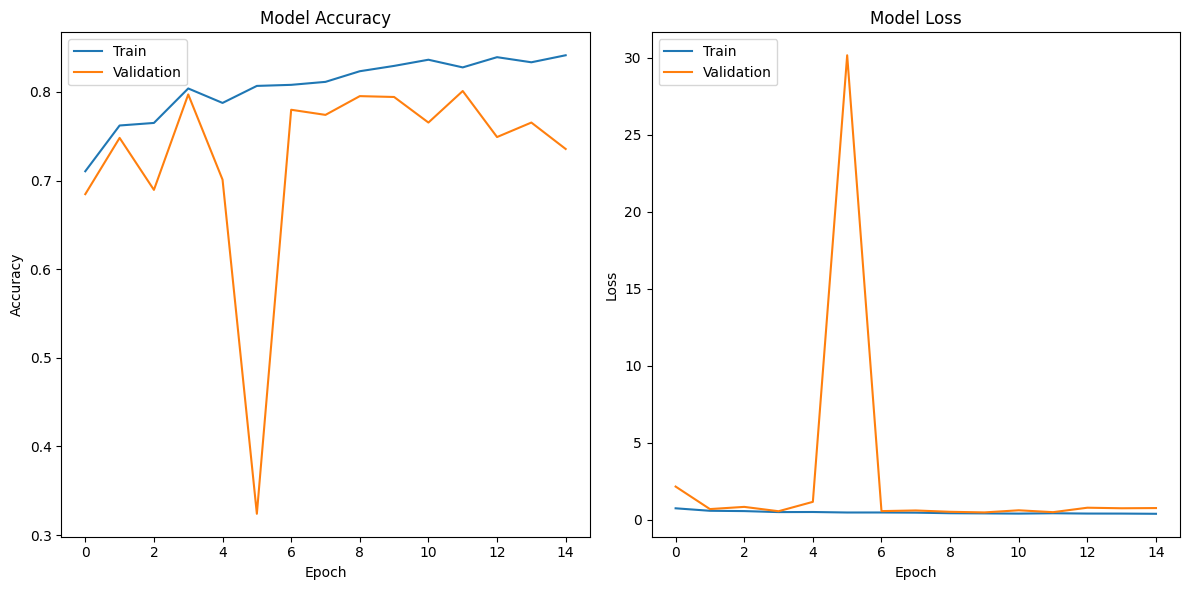

In [ ]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Show the plots
    plt.tight_layout()
    plt.show()

plot_training_history(history_multi_class)

In [ ]:
multi_class_model.save(f'{drive_path}/multi_class_best_model.keras')

## Multi class model evaluation

1. Make sure you've run the multi-class preprocessing section before
2. Download the multi class model and its weights and get its evaluation



In [17]:
import gdown
from keras.models import load_model
file_id = '10CAUCC35rxg5nXN_3SGlAP709AB7t3-s'

download_url = f"https://drive.google.com/uc?id={file_id}"
model_filename = 'multi_class_best_model.keras'

# Download the model file
gdown.download(download_url, model_filename, quiet=False)

# Load the downloaded model using Keras
model_tl = load_model(model_filename)


Downloading...
From (original): https://drive.google.com/uc?id=10CAUCC35rxg5nXN_3SGlAP709AB7t3-s
From (redirected): https://drive.google.com/uc?id=10CAUCC35rxg5nXN_3SGlAP709AB7t3-s&confirm=t&uuid=98725f3a-4d4e-44f1-a6fe-bc5ee8b7eab6
To: /content/multi_class_best_model.keras
100%|██████████| 250M/250M [00:04<00:00, 61.6MB/s]


In [20]:

model_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

evaluation_result = model_tl.evaluate(test_generator_mc)

test_loss = evaluation_result[0]
test_accuracy = evaluation_result[1]

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


32/32 [==============================] - 9s 172ms/step - loss: 0.5154 - accuracy: 0.8446
Test Loss: 0.5154
Test Accuracy: 84.46%


- Let's predict and present confusion matrix on the test set

32/32 [==============================] - 6s 157ms/step
Accuracy: 84.46%


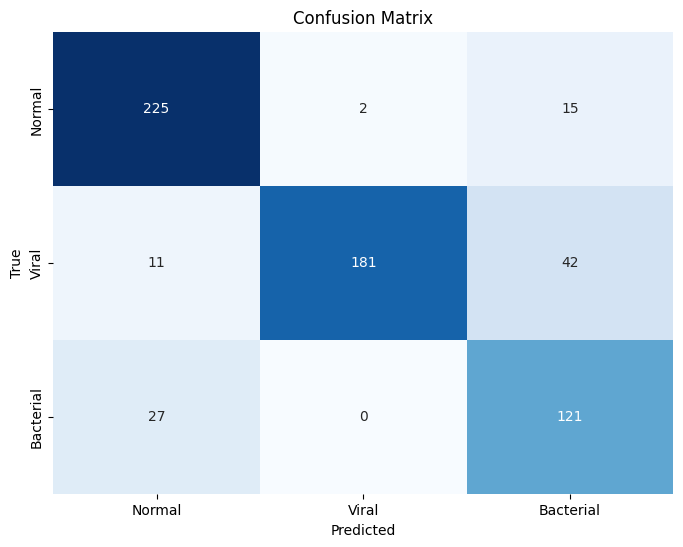

In [ ]:

y_pred = model_tl.predict(test_generator_mc)
y_pred = np.argmax(y_pred, axis=1)

y_true = test_generator_mc.classes

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Define class labels
class_labels = ['Normal', 'Viral', 'Bacterial']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


- Here you can upload your own file and get its prediction

In [ ]:

class_labels = ['Healthy', 'Viral Pneumonia', 'Bacterial Pneumonia']

def preprocess_image(image_path):
    print("Image path:", image_path)  # Debugging statement
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values
    return img_array

def predict_image(image_path):
    img_array = preprocess_image(image_path)
    prediction = model_tl.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]
    return predicted_class

image_path = '/content/chest_xray/test/PNEUMONIA/person126_bacteria_598.jpeg'

predicted = predict_image(image_path)

print("Predicted class:", predicted)


Image path: /content/chest_xray/test/PNEUMONIA/person126_bacteria_598.jpeg
1/1 [==============================] - 0s 25ms/step
Predicted class: Healthy


# <font color=green>KNN classification</font>
In the subsequent code, we will demonstrate the application of a previously identified successful neural network for classifying new images. The process involves leveraging the embedding vector generated by the classification network and implementing KNN for image classification.

## Binary KNN classification

To run the knn classification independently:
- Run first the binary model generators and also the binary model loading

t-SNE visualization and KNN classification using embedding vector


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from keras.models import Model

#Extract labels
train_labels = []
test_labels = []

for i in range (len(train_generator)):
  _, batch_labels = train_generator[i]
  train_labels. extend (batch_labels)

for i in range(len(test_generator)):
  _, batch_labels = test_generator [i]
  test_labels.extend (batch_labels)

train_labels = np.array (train_labels)
test_labels = np. array (test_labels)

embedding_model = Model(inputs=binary_model.input, outputs=binary_model.layers[-5].output)

train_embeddings = embedding_model.predict(train_generator, steps=len(train_generator), verbose=1)
test_embeddings = embedding_model.predict(test_generator,steps=len (test_generator), verbose=1)

train_embeddings_flat = train_embeddings.reshape(train_embeddings.shape[0], -1)
test_embeddings_flat = test_embeddings.reshape(test_embeddings.shape[0], -1)

train_embeddings_flat = train_embeddings.reshape(train_embeddings.shape[0], -1)
test_embeddings_flat = test_embeddings.reshape(test_embeddings.shape[0], -1)

knn_classifier = KNeighborsClassifier(n_neighbors=5, weights= 'distance')
knn_classifier. fit(train_embeddings_flat, train_labels)
predictions = knn_classifier.predict(test_embeddings_flat)
accuracy = knn_classifier.score(test_embeddings_flat, test_labels)
print("KNN accuracy for binary model: {:.2f}%".format(accuracy * 100))

20/20 [==============================] - 4s 180ms/step
KNN accuracy for binary model: 87.98%


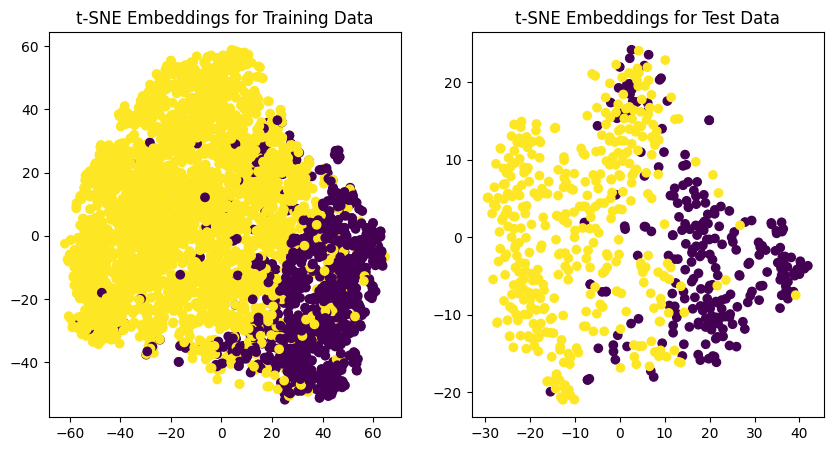

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
train_tsne_embeddings = tsne.fit_transform(train_embeddings_flat)

test_tsne_embeddings = tsne.fit_transform(test_embeddings_flat)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(train_tsne_embeddings[:, 0], train_tsne_embeddings[:, 1], c=train_labels, cmap='viridis')
plt.title('t-SNE Embeddings for Training Data')

plt.subplot(1, 2, 2)
plt.scatter(test_tsne_embeddings[:, 0], test_tsne_embeddings[:, 1], c=test_labels, cmap='viridis')
plt.title('t-SNE Embeddings for Test Data')

plt.show()


## Multi-class KNN classification

To run the knn classification independently:
- Run first the multi class model generators and also the multi class model loading


t-SNE visualization and KNN classification using embedding vector




In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from keras.models import Model

#Extract labels
train_labels = []
test_labels = []

for i in range (len(train_generator_mc)):
  _, batch_labels = train_generator_mc[i]
  train_labels.extend (batch_labels)

for i in range(len(test_generator_mc)):
  _, batch_labels = test_generator_mc[i]
  test_labels.extend(batch_labels)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

embedding_model = Model(inputs=model_tl.input, outputs=model_tl.layers[-8].output)
# Create emmbedings for the train and test
train_embeddings = embedding_model.predict(train_generator_mc, steps=len(train_generator_mc), verbose=1)
test_embeddings = embedding_model.predict(test_generator_mc,steps=len(test_generator_mc), verbose=1)

train_embeddings_flat = train_embeddings.reshape(train_embeddings.shape[0], -1)
test_embeddings_flat = test_embeddings.reshape(test_embeddings.shape[0], -1)

# Train and predict with KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_classifier.fit(train_embeddings_flat, train_labels)
predictions = knn_classifier.predict(test_embeddings_flat)
accuracy = knn_classifier.score(test_embeddings_flat, test_labels)
print("KNN accuracy for multi class model: {:.2f}%".format(accuracy * 100))

32/32 [==============================] - 5s 157ms/step
KNN accuracy for multi class model: 80.77%


<ipython-input-44-f3016c23c307>:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(train_tsne_embeddings[:, 0], train_tsne_embeddings[:, 1], c=train_labels, cmap='viridis')
<ipython-input-44-f3016c23c307>:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(test_tsne_embeddings[:, 0], test_tsne_embeddings[:, 1], c=test_labels, cmap='viridis')


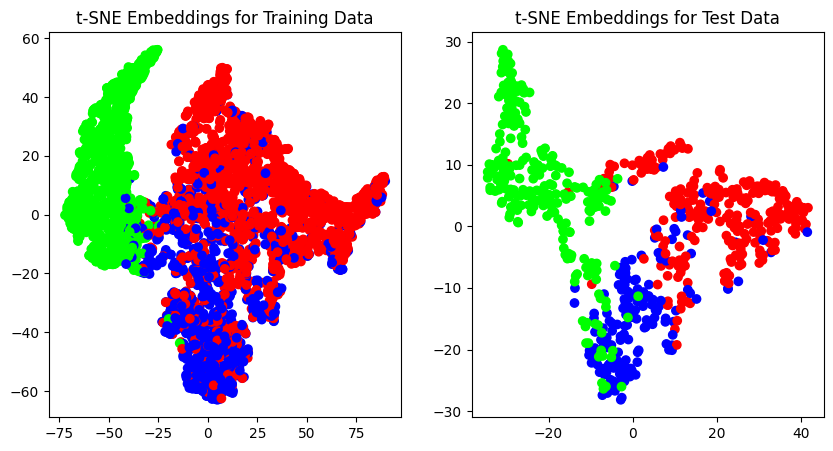

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Compute t-SNE embeddings for training data
tsne = TSNE(n_components=2, random_state=42)
train_tsne_embeddings = tsne.fit_transform(train_embeddings_flat)

# Compute t-SNE embeddings for test data
test_tsne_embeddings = tsne.fit_transform(test_embeddings_flat)

# Plot t-SNE embeddings for training data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(train_tsne_embeddings[:, 0], train_tsne_embeddings[:, 1], c=train_labels, cmap='viridis')
plt.title('t-SNE Embeddings for Training Data')

# Plot t-SNE embeddings for test data
plt.subplot(1, 2, 2)
plt.scatter(test_tsne_embeddings[:, 0], test_tsne_embeddings[:, 1], c=test_labels, cmap='viridis')
plt.title('t-SNE Embeddings for Test Data')

plt.show()


# <font color=purple> Anomaly Detection</font>
In this section, we exclusively possess data for "healthy" images. The objective is to implement anomaly detection techniques to identify potentially "diseased" images. By training models on healthy images and detecting deviations or reconstruction errors, we aim to uncover anomalies indicative of diseases or abnormalities.

## Preprocessing data for autoencoder model

In [ ]:
# DataFrames
train_df = create_dataframe_from_directory(train_dir)
val_df = create_dataframe_from_directory(val_dir)
test_df = create_dataframe_from_directory(test_dir)
batch_size=32

normal_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

train_normal_df = train_df[train_df['class'] == 'NORMAL']

train_normal_df, val_normal_df  = train_test_split(train_normal_df, test_size=0.2, shuffle=True, random_state=42)


normal_generator = normal_datagen.flow_from_dataframe(
    dataframe=train_normal_df,
    x_col='file_path',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='input',
    shuffle=True,
)


val_ae_datagen = ImageDataGenerator(
    rescale=1./255
)
val_ae_generator = val_ae_datagen.flow_from_dataframe(
    dataframe=val_normal_df,
    x_col='file_path',
    y_col='class',
     target_size=(224, 224),
    batch_size=32,
    class_mode='input',
    shuffle=False
)
test_ae_datagen = ImageDataGenerator(
    rescale=1./255
)
test_ae_generator = test_ae_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='class',
     target_size=(224, 224),
    batch_size=32,
    class_mode='input',
    shuffle=False
)


Found 1072 validated image filenames.
Found 269 validated image filenames.
Found 624 validated image filenames.


- changed to normal in validation
added dropout(0.2)
- we increased model layers
- change from mse to mae
- increased the number of filters in both the encoder and decoder sections

## Build and train the autoencoder model

In [ ]:
from keras.layers import Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, Input, Concatenate
from keras.losses import MeanAbsoluteError

input_shape=(224, 224, 3)
inputs = Input(shape=input_shape)


# Encoder
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', strides=2)(inputs)
x = Dropout(0.2)(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', strides=2)(x)
x = Dropout(0.2)(x)
x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', strides=2)(x)
x = Dropout(0.2)(x)
encoded = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', strides=2)(x)

# Decoder
x = Conv2DTranspose(filters=128, kernel_size=(3,3), activation='relu', padding='same', strides=2)(encoded)
x = Dropout(0.2)(x)
x = Conv2DTranspose(filters=64, kernel_size=(3,3), activation='relu', padding='same', strides=2)(x)
x = Dropout(0.2)(x)
x = Conv2DTranspose(filters=32, kernel_size=(3,3), activation='relu', padding='same', strides=2)(x)
x = Dropout(0.2)(x)
x = Conv2DTranspose(filters=16, kernel_size=(3,3), activation='relu', padding='same', strides=2)(x)
x = Dropout(0.2)(x)
decoded = Conv2DTranspose(filters=3, kernel_size=(3,3), activation='sigmoid', padding='same', strides=2)(x)



# Autoencoder Model
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mae')

autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_60 (Conv2D)          (None, 112, 112, 32)      896       
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_61 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 64)        0         
                                                             

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f'{drive_path}/ae_best_model', save_best_only=True)

#Train the autoencoder
ae_history = autoencoder.fit(normal_generator, epochs=20, steps_per_epoch=len(normal_generator), validation_data=val_ae_generator, validation_steps=len(val_ae_generator), callbacks=[early_stopping, model_checkpoint])


Epoch 1/20
34/34 [==============================] - 40s 1s/step - loss: 0.1963 - val_loss: 0.1645
Epoch 2/20
34/34 [==============================] - 35s 1s/step - loss: 0.1584 - val_loss: 0.1588
Epoch 3/20
34/34 [==============================] - 35s 1s/step - loss: 0.1461 - val_loss: 0.1513
Epoch 4/20
34/34 [==============================] - 35s 1s/step - loss: 0.1405 - val_loss: 0.1444
Epoch 5/20
34/34 [==============================] - 34s 989ms/step - loss: 0.1353 - val_loss: 0.1505
Epoch 6/20
34/34 [==============================] - 33s 978ms/step - loss: 0.1302 - val_loss: 0.1500
Epoch 7/20
34/34 [==============================] - 35s 1s/step - loss: 0.1259 - val_loss: 0.1364
Epoch 8/20
34/34 [==============================] - 35s 1s/step - loss: 0.1224 - val_loss: 0.1360
Epoch 9/20
34/34 [==============================] - 33s 965ms/step - loss: 0.1198 - val_loss: 0.1394
Epoch 10/20
34/34 [==============================] - 35s 1s/step - loss: 0.1171 - val_loss: 0.1315
Epoch 11/2

In [ ]:
autoencoder.save(f'{drive_path}/ae_best_model.keras')

In [ ]:
# Get reconstruction error on training set
train_data = []
for i in range(len(normal_generator)):
    batch = normal_generator[i]
    train_data.append(batch[0])
train_data = np.concatenate(train_data)

X_train_decoded = autoencoder.predict(train_data)
train_recon_error = np.mean(np.abs(train_data - X_train_decoded), axis=(1,2))

# Set threshold as a percentile of the training error
anomaly_threshold = np.percentile(train_recon_error, 99) # can be defined

34/34 [==============================] - 0s 7ms/step


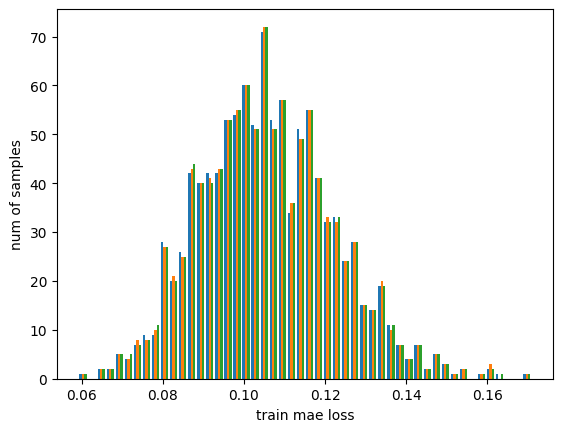

In [ ]:
plt.hist(train_recon_error, bins=50)
plt.xlabel("train mae loss")
plt.ylabel("num of samples")
plt.show()

## Evaluate the autoencoder performance

In [ ]:
# Evaluate on test set using threshold
test_data = []
for i in range(len(test_ae_generator)):
    batch = test_ae_generator[i]
    test_data.append(batch[0])
test_data = np.concatenate(test_data)

X_test_decoded = autoencoder.predict(test_data)

test_recon_error = np.mean(np.abs(test_data - X_test_decoded), axis=(1,2))
anomalies = np.where(test_recon_error > anomaly_threshold)

# Get pneumonia label indices
pneumonia_rows = test_df[test_df['class'] == 'PNEUMONIA']  # Find rows where label is 'PNEUMONIA'
pneumonia_indices = pneumonia_rows.index.values  # Get the indices of these rows

# Calculate anomaly accuracy
anomaly_accuracy = np.mean(np.isin(pneumonia_indices, anomalies[0]))
print("Anomaly accuracy:{:.2f}%".format(anomaly_accuracy * 100))



20/20 [==============================] - 0s 7ms/step
Anomaly accuracy:0.51%


plot 5 images - original vs reconstructed

1/1 [==============================] - 0s 23ms/step


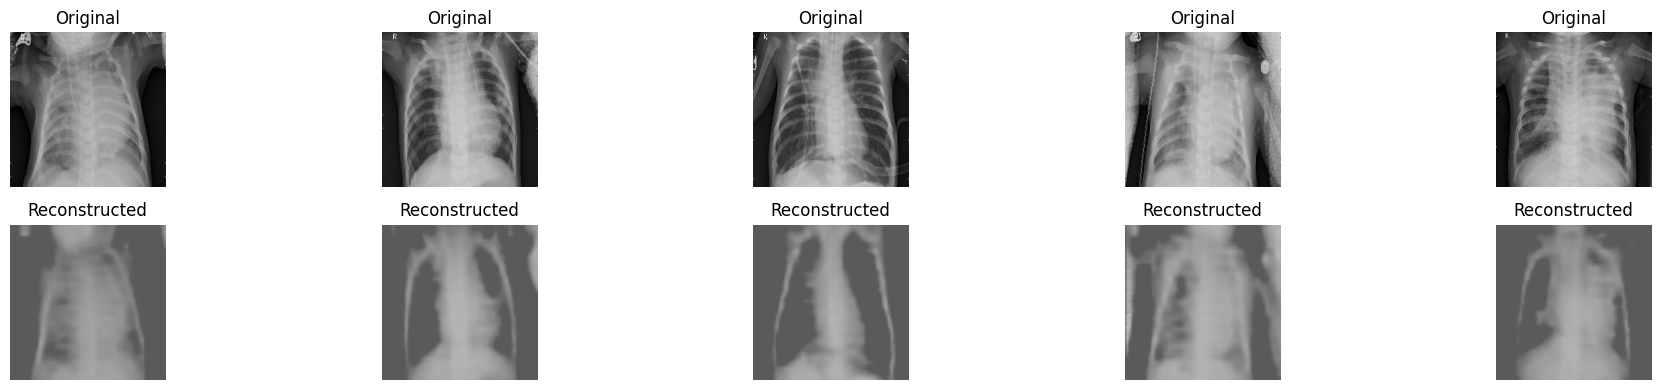

In [ ]:
import matplotlib.pyplot as plt

# Get sample images from test set
test_ae_generator.reset()  # Reset the generator to start from the beginning
batch = test_ae_generator.next()  # Get the next batch of data
original_images = batch[0][:5]  # Extract the images from the batch

# Generate reconstructions
reconstructions = autoencoder.predict(original_images)

# Plot images
fig, axs = plt.subplots(2, 5, figsize=(20, 4))
for i in range(5):
    axs[0,i].imshow(original_images[i])
    axs[0,i].set_title('Original')
    axs[0,i].axis('off')

    axs[1,i].imshow(reconstructions[i])
    axs[1,i].set_title('Reconstructed')
    axs[1,i].axis('off')

plt.tight_layout()
plt.show()
